In [4]:
!pip install forex-python

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import time
import joblib
import datetime

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import StandardScaler

from forex_python.converter import CurrencyRates

###RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

In [6]:
def change_currency(val, curr_from, curr_to):
  if curr_from != curr_to:
    curr_from = curr_from.upper()
    curr_to = curr_to.upper()
    c = CurrencyRates()
    return round(val/c.get_rate(curr_to, curr_from, datetime.datetime.now()))

In [7]:
def remove_mark(value):
    marks = ['>', '<', '-', '+', '_', ' ', '  ', ',']
    for mark in marks:
        if pd.notna(value) and mark in value:
            return value.replace(mark, '')
    return value

In [8]:
def remove_blanc(value):
    if value == '':
        value = 0
        return value

In [9]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)

    # Display results
    print("Regression Model Evaluation:")
    print("===========================")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

In [10]:
def api_to_df(url):
    response = requests.get(url)
    content = response.json()
    return pd.DataFrame.from_records(content)


In [11]:
def to_csv_date(df, filename):
    current_date = pd.Timestamp("today").strftime("%m%d%Y")
    df.to_csv(filename + '_' + current_date + '_.csv', index = False)


In [12]:
def remove_null_col(df):
    return df.dropna(axis=1, how='all', inplace = False)

In [13]:
def flatten_list_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, list) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
    new_columns = list(range(len(new_df.columns)))
    new_df.columns = new_columns
    return new_df

In [14]:
def flatten_dict_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, dict) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
#     new_columns = list(range(len(new_df.columns)))
#     new_df.columns = new_columns
    new_df = remove_null_col(new_df)
    return new_df

In [15]:
def unpack_nested_col(nested_col, key_name):
    unpacked_col = {}
    nested_col_unpacked = nested_col.apply(pd.Series)
    for i, col in enumerate(nested_col_unpacked.columns):
        unpacked_col[f'{key_name}_{i}'] = nested_col_unpacked[col].apply(pd.Series)
        if 0 in unpacked_col[f'{key_name}_{i}'].columns:
            if unpacked_col[f'{key_name}_{i}'][0].isna().all():
                unpacked_col[f'{key_name}_{i}'].drop(columns = 0, inplace = True)
    return unpacked_col

In [16]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    return df

In [17]:
def replace_cols(recipient_df, col_replaced, donor_df, col_replacing):
    recipient_df.drop(columns = col_replaced, inplace = True)
    recipient_df = pd.concat([recipient_df, donor_df[col_replacing]])
    return recipient_df

## Reading initial data from API. In this step, we accept all offers from the API, but only receive general information. In order to complete the data, we also read each offer separately using its individual API.


## Unpacking the data


In [18]:
df_init = api_to_df('https://justjoin.it/api/offers')

df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12691 entries, 0 to 12690
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    12691 non-null  object
 1   street                   12689 non-null  object
 2   city                     12691 non-null  object
 3   country_code             12685 non-null  object
 4   address_text             12691 non-null  object
 5   marker_icon              12691 non-null  object
 6   workplace_type           12691 non-null  object
 7   company_name             12691 non-null  object
 8   company_url              12691 non-null  object
 9   company_size             12691 non-null  object
 10  experience_level         12691 non-null  object
 11  latitude                 12691 non-null  object
 12  longitude                12691 non-null  object
 13  published_at             12691 non-null  object
 14  remote_interview         12691 non-nul

## Select the subset of the data - only "data" marker icon

In [19]:
# Limit observations to those that have flag 'data'
df_data = df_init[df_init['marker_icon'] == 'data']
df_data.reset_index(drop=True, inplace = True)

## Reading detailed data for every separete offer from API

In [20]:
json_data = []

In [21]:
offers = list(df_data.id)

In [22]:
len(offers)

1063

In [23]:
for offer in offers:
  url = f'https://justjoin.it/api/offers/{offer}'
  response = requests.get(url)
  json_obj = response.json()
#   initial_df = pd.json_normalize(json_obj)
  json_data.append(json_obj)
#   time.sleep(0.5)

In [24]:
df_data_offers = pd.DataFrame(json_data)
to_csv_date(df_data_offers, 'df_data_offers')

In [25]:
df_data_offers.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   apply_body               0 non-null      object
 1   title                    1063 non-null   object
 2   street                   1063 non-null   object
 3   city                     1063 non-null   object
 4   country_code             1062 non-null   object
 5   address_text             1063 non-null   object
 6   marker_icon              1063 non-null   object
 7   workplace_type           1063 non-null   object
 8   company_name             1063 non-null   object
 9   company_url              1063 non-null   object
 10  company_size             1063 non-null   object
 11  experience_level         1063 non-null   object
 12  latitude                 1063 non-null   object
 13  longitude                1063 non-null   object
 14  apply_url                704 non-null   

### Dealing with skills

In [26]:
print(df_data_offers['skills'][0])

[{'name': 'Azure', 'level': 5}, {'name': 'SQL', 'level': 5}, {'name': 'Java', 'level': 4}, {'name': 'SAP', 'level': 1}]


In [27]:
# Putting all skills into one column

old_data = df_data_offers.to_dict(orient='records')
new_data = []

for index, skills_list in enumerate(df_data_offers['skills']):
    for skill in skills_list:
        new_row = old_data[index].copy()
        new_row['skill_name'] = skill['name']
        new_row['skill_level'] = skill['level']
        new_data.append(new_row)

In [28]:
new_df = pd.DataFrame(new_data)

In [29]:
new_df.sample()

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
5119,None,BI Developer - SQL/Power BI,Centrum,Białystok,PL,"Centrum, Białystok",data,remote,QBICO Sp. z o.o.,https://qbico.pl/,...,<div><strong>Kim jesteśmy?</strong></div><div>...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'T-SQL', 'level': 3}, {'name': 'Powe...",True,"[{'type': 'b2b', 'salary': {'from': 10000, 'to...",[{'slug': 'qbico-sp-z-o-o-bi-developer-sql-pow...,NaN,T-SQL,3


In [30]:
new_df.skill_name.unique()

array(['Azure', 'SQL', 'Java', 'SAP', 'Data Pipelines', 'Data modeling',
       'Data Engineering', 'Data Warehousing', 'Snowflake', 'Looker',
       'Kafka', 'Airflow', 'Power BI', 'Python', 'Data cloud',
       'Data engineer', 'AWS', 'Google Cloud Platform', 'Spark', 'MS SQL',
       'T-SQL', 'MVC', 'SSIS', 'SSRS', 'Data', 'Big Data', 'Torchscript',
       'ONNX', 'Docker', 'Business Analysis',
       'Private Capital fund industry', 'Project Management', 'eFront',
       'Multifond', 'Arc Regulatory', 'Fund ID', 'Arep', 'SQL Profiler',
       'WebService', 'Oracle BI', 'PL/SQL', 'Powershell', 'VBScript',
       'Graph API', 'MS', 'AD', 'MECM', 'MS/Postgre SQL',
       'Technologie Voice i eCom', 'Confluent Kafka', 'Hadoop', 'Linux',
       'Ansible', 'JupyterHub', 'PostgreSQL', 'MapR',
       'HPE Ezmeral Data Fabric', 'OpenShift', 'data analyst', 'MS Excel',
       'Niemiecki', 'GCP', 'Kubernetes', 'REST API', 'MS Office',
       'PowerBi', 'analiza', 'PHP', 'MySQL', 'Symfony', 'N

In [31]:
new_df.skill_name.nunique()

521

In [32]:
# Po co to?

clean_df = new_df.copy()
clean_df = standardize_text(clean_df, "title")
clean_df = standardize_text(clean_df, "skill_name")

In [33]:
clean_df.head(5)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
0,None,implementation engineer,"Zabłocie 43A, 30-701",Kraków,PL,"Zabłocie 43A, 30-701, Kraków",data,remote,N-iX,https://careers.n-ix.com/,...,<div>We are looking for Implementation Enginee...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Azure', 'level': 5}, {'name': 'SQL'...",True,"[{'type': 'b2b', 'salary': {'from': 5500, 'to'...","[{'slug': 'n-ix-implementation-engineer', 'cit...","{'url': '/brands/story/n-ix', 'short_descripti...",azure,5
1,None,implementation engineer,"Zabłocie 43A, 30-701",Kraków,PL,"Zabłocie 43A, 30-701, Kraków",data,remote,N-iX,https://careers.n-ix.com/,...,<div>We are looking for Implementation Enginee...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Azure', 'level': 5}, {'name': 'SQL'...",True,"[{'type': 'b2b', 'salary': {'from': 5500, 'to'...","[{'slug': 'n-ix-implementation-engineer', 'cit...","{'url': '/brands/story/n-ix', 'short_descripti...",sql,5
2,None,implementation engineer,"Zabłocie 43A, 30-701",Kraków,PL,"Zabłocie 43A, 30-701, Kraków",data,remote,N-iX,https://careers.n-ix.com/,...,<div>We are looking for Implementation Enginee...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Azure', 'level': 5}, {'name': 'SQL'...",True,"[{'type': 'b2b', 'salary': {'from': 5500, 'to'...","[{'slug': 'n-ix-implementation-engineer', 'cit...","{'url': '/brands/story/n-ix', 'short_descripti...",java,4
3,None,implementation engineer,"Zabłocie 43A, 30-701",Kraków,PL,"Zabłocie 43A, 30-701, Kraków",data,remote,N-iX,https://careers.n-ix.com/,...,<div>We are looking for Implementation Enginee...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Azure', 'level': 5}, {'name': 'SQL'...",True,"[{'type': 'b2b', 'salary': {'from': 5500, 'to'...","[{'slug': 'n-ix-implementation-engineer', 'cit...","{'url': '/brands/story/n-ix', 'short_descripti...",sap,1
4,None,data warehouse architect,"Lubostroń, 1",Kraków,PL,"Lubostroń, 1, Kraków",data,remote,Kitopi - SATISFYING THE WORLD’S APPETITE,https://kitopi.com,...,"<div>\n<a href=""https://www.kitopi.com/"" targe...",https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Data Pipelines', 'level': 5}, {'nam...",True,"[{'type': 'b2b', 'salary': {'from': 32000, 'to...",[{'slug': 'kitopi-satisfying-the-world-s-appet...,"{'url': '/brands/story/kitopi', 'short_descrip...",data pipelines,5


In [34]:
top_values = clean_df['skill_name'].value_counts().head(20)
top_20_skills = list(top_values.index)

In [35]:
print(top_20_skills)

['sql', 'python', 'english', 'power bi', 'aws', 'etl', 'java', 'azure', 'oracle', 'databricks', 'big data', 'snowflake', 'scala', 'data', 'machine learning', 'spark', 'pl/sql', 'dwh', 'gcp', 'databases']


In [122]:
with open('output.txt', 'w') as file:
    for item in top_20_skills:
        file.write(str(item) + '\n')

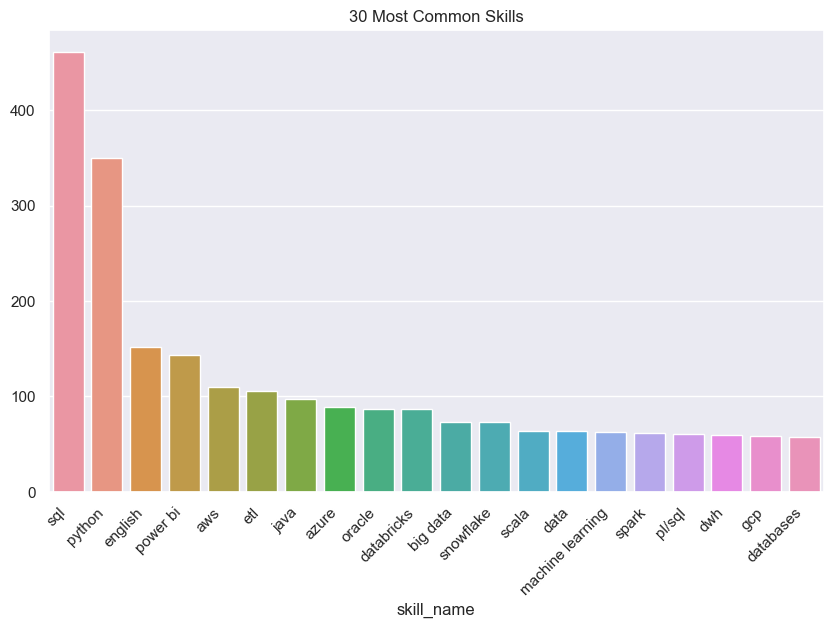

In [36]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.barplot(x=clean_df['skill_name'].value_counts().iloc[:20].index, y=clean_df['skill_name'].value_counts().iloc[:20].values)
plot.set_title('20 Most Common Skills')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [37]:
# Sprawdzanie i zamiana wartości
common_skills_df = clean_df.copy()
mask = ~common_skills_df['skill_name'].isin(top_20_skills)
common_skills_df.loc[mask, 'skill_name'] = None


In [38]:
most_common_skills_df = common_skills_df.dropna(subset=['skill_name'])

In [39]:
most_common_skills_df.reset_index(drop=True, inplace = True)
most_common_skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2317 entries, 0 to 2316
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   apply_body               0 non-null      object
 1   title                    2317 non-null   object
 2   street                   2317 non-null   object
 3   city                     2317 non-null   object
 4   country_code             2316 non-null   object
 5   address_text             2317 non-null   object
 6   marker_icon              2317 non-null   object
 7   workplace_type           2317 non-null   object
 8   company_name             2317 non-null   object
 9   company_url              2317 non-null   object
 10  company_size             2317 non-null   object
 11  experience_level         2317 non-null   object
 12  latitude                 2317 non-null   object
 13  longitude                2317 non-null   object
 14  apply_url                1496 non-null  

In [41]:
most_common_skills_df.columns

Index(['apply_body', 'title', 'street', 'city', 'country_code', 'address_text',
       'marker_icon', 'workplace_type', 'company_name', 'company_url',
       'company_size', 'experience_level', 'latitude', 'longitude',
       'apply_url', 'published_at', 'remote_interview', 'video_key',
       'video_provider', 'open_to_hire_ukrainians', 'future_consent_title',
       'future_consent', 'information_clause', 'custom_consent_title',
       'custom_consent', 'id', 'tags', 'body', 'company_logo_url',
       'banner_url', 'skills', 'remote', 'employment_types', 'multilocation',
       'company_profile', 'skill_name', 'skill_level'],
      dtype='object')

In [42]:
dummies = pd.get_dummies(most_common_skills_df['skill_name'], prefix='skill')

for col in dummies.columns:
    dummies[col] *=  most_common_skills_df['skill_level']

# Dołączanie kolumn dummies
aggregated_df = pd.concat([most_common_skills_df, dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_df = aggregated_df.drop('skill_name', axis=1)
aggregated_df = aggregated_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_df = aggregated_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_df = aggregated_df.drop('skill_level', axis=1)

In [43]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       908 non-null    object
 1   apply_body               0 non-null      object
 2   title                    908 non-null    object
 3   street                   908 non-null    object
 4   city                     908 non-null    object
 5   country_code             907 non-null    object
 6   address_text             908 non-null    object
 7   marker_icon              908 non-null    object
 8   workplace_type           908 non-null    object
 9   company_name             908 non-null    object
 10  company_url              908 non-null    object
 11  company_size             908 non-null    object
 12  experience_level         908 non-null    object
 13  latitude                 908 non-null    object
 14  longitude                908 non-null    o

## Dealing with experience level - label encoding

In [44]:
aggregated_df['experience_level'].unique()

array(['senior', 'mid', 'junior'], dtype=object)

In [45]:
label_encoder = preprocessing.LabelEncoder()
aggregated_df['experience_level']= label_encoder.fit_transform(aggregated_df['experience_level'])

## Dealing with 'workplace_type', 'country_code'

In [46]:
aggregated_df['workplace_type'].unique()

array(['remote', 'partly_remote', 'office'], dtype=object)

In [47]:
aggregated_df['country_code'].unique()

array(['PL', 'SK', 'CZ', 'HU', 'AT', 'SI', 'RO', 'MT', 'DE', 'UA', None,
       'EE'], dtype=object)

In [48]:
aggregated_df['workplace_type']= label_encoder.fit_transform(aggregated_df['workplace_type'])
aggregated_df['country_code']= label_encoder.fit_transform(aggregated_df['country_code'])

## Dealing with salaries

In [49]:
df_employment_types = aggregated_df['employment_types'].apply(pd.Series)
df_employment_types.sample()

,0,1
566,"{'type': 'permanent', 'salary': None}",NaN


In [50]:
df_employment_type_1 = df_employment_types[0].apply(pd.Series, dtype='object')
df_employment_type_1= pd.concat([df_employment_type_1.drop(['salary'], axis=1),
                                 df_employment_type_1['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_1.sample()

,type,from,to,currency
782,b2b,26000.0,31920.0,pln


In [51]:
df_employment_type_2 = df_employment_types[1].apply(pd.Series, dtype='object')
df_employment_type_2 = pd.concat([df_employment_type_2.drop(['salary'], axis=1),
                                  df_employment_type_2['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_2.drop(columns=0, inplace = True)
df_employment_type_2.sample(10)

,type,from,to,currency
641,NaN,NaN,NaN,NaN
403,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN
701,b2b,NaN,NaN,NaN
149,NaN,NaN,NaN,NaN
573,b2b,NaN,NaN,NaN
856,NaN,NaN,NaN,NaN
712,NaN,NaN,NaN,NaN
799,NaN,NaN,NaN,NaN


In [52]:
df_no_employment = aggregated_df.drop(columns = 'employment_types')
df_employment_1 = pd.concat([df_no_employment, df_employment_type_1], axis = 1)
df_employment_2 = pd.concat([df_no_employment, df_employment_type_2], axis = 1)
df_employment = pd.concat([df_employment_1, df_employment_2])
df_employment.dropna(subset=['type'], inplace = True)
df_employment.reset_index(drop=True, inplace = True)
df_employment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1096 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1096 non-null   object 
 3   street                   1096 non-null   object 
 4   city                     1096 non-null   object 
 5   country_code             1096 non-null   int64  
 6   address_text             1096 non-null   object 
 7   marker_icon              1096 non-null   object 
 8   workplace_type           1096 non-null   int64  
 9   company_name             1096 non-null   object 
 10  company_url              1096 non-null   object 
 11  company_size             1096 non-null   object 
 12  experience_level         1096 non-null   int64  
 13  latitude                 1096 non-null   object 
 14  longitude               

In [53]:
df_employment['type']= label_encoder.fit_transform(df_employment['type'])

### Convert all currencies to PLN

In [54]:
currency_list = list(df_employment[df_employment['from'].notna()]['currency'].unique())
currency_list

['pln', 'eur', 'usd']

In [55]:
selected_currency  = 'pln'
foreign_currencies = currency_list.copy()
foreign_currencies.remove(selected_currency)

In [56]:
df_with_salary = df_employment[df_employment['currency'].notna()]
df_no_salary = df_employment[df_employment['currency'].isna()]

In [57]:
df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)
                                              if row['currency'] != selected_currency and pd.notna(row['currency'])
                                              else row['from'], axis=1)

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_69966/2430910949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)


In [58]:
df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)
                                            if row['currency'] != selected_currency and pd.notna(row['currency'])
                                            else row['to'], axis=1)

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_69966/1341338040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)


In [59]:
df_with_salary.loc[df_with_salary['currency'] != selected_currency, 'currency'] = selected_currency

In [60]:
df_pln = pd.concat([df_with_salary, df_no_salary])
df_pln.reset_index(drop=True, inplace = True)
df_pln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1096 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1096 non-null   object 
 3   street                   1096 non-null   object 
 4   city                     1096 non-null   object 
 5   country_code             1096 non-null   int64  
 6   address_text             1096 non-null   object 
 7   marker_icon              1096 non-null   object 
 8   workplace_type           1096 non-null   int64  
 9   company_name             1096 non-null   object 
 10  company_url              1096 non-null   object 
 11  company_size             1096 non-null   object 
 12  experience_level         1096 non-null   int64  
 13  latitude                 1096 non-null   object 
 14  longitude               

at this stage df includes:
- offers with marker icon 'data'
- ordered employment column
- cleaned company_size column
- selected offers with the 30 most popular skills among 'data', both with given and unknown salary
- experience_level, country_code, employment_type, workplace_type and skills encoded columns
- offers in a foreign currency converted into PLN

In [61]:
#cleaning up and encoding company sizes

#cleaning up sizes that contain '-'
company_size_df = df_pln[df_pln['company_size'].str.contains('-')][['company_size']]
company_size_df

,company_size
5,11-50
31,51-200
32,51-200
33,51-200
34,51-200
...,...
1053,11-50
1054,11-50
1055,11-50
1060,-


In [62]:
company_size_df['company_size_1'] = company_size_df['company_size'].str.split('-').str[0]
company_size_df['company_size_2']  = company_size_df['company_size'].str.split('-').str[-1]

In [63]:
company_size_df[company_size_df['company_size']=='-']

,company_size,company_size_1,company_size_2
877,-,,
878,-,,
1060,-,,


In [64]:
company_size_df = company_size_df[company_size_df['company_size'] != '-']
company_size_df[company_size_df['company_size']=='-']

,company_size,company_size_1,company_size_2


In [65]:
# company_size_df = company_size_df.copy()
company_size_df['company_size_1'] = pd.to_numeric(company_size_df['company_size_1'])
company_size_df['company_size_2'] = pd.to_numeric(company_size_df['company_size_2'])
company_size_df['avg_company_size'] = (company_size_df['company_size_1'] + company_size_df['company_size_2']) / 2

company_size_df = company_size_df[['avg_company_size']]
company_size_df

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_69966/2302636781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_size_df['company_size_1'] = pd.to_numeric(company_size_df['company_size_1'])
/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_69966/2302636781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_size_df['company_size_2'] = pd.to_numeric(company_size_df['company_size_2'])
/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_69966/2302636781.py:4: Sett

,avg_company_size
5,30.5
31,125.5
32,125.5
33,125.5
34,125.5
...,...
1052,30.5
1053,30.5
1054,30.5
1055,30.5


In [66]:
df_avg_company_size = pd.merge(df_pln, company_size_df, left_index=True, right_index=True, how = 'outer')

In [67]:
df_avg_company_size['company_size'] = df_avg_company_size['company_size'].apply(remove_mark)
df_avg_company_size['company_size'].unique()

array(['250', '6000', '1150', '200', '30', '51200', '1001  5000', '100',
       '500', '6080', '60000', '150', '110', '1000', '2030', '50',
       '300000', '125', '1025', '120', '1020', '3040', '450', '40',
       '1400', '1530', '7000', '5011000', '750', '350', '80', '87',
       '101500', '50100', '60', '1520', '200250', '50  100', '2000',
       '900', '460', '430', '300', '2650', '22 200', '30000', '1525',
       ' 30', '1500', '280', '2 000', '100200', '51100', '170', '5000',
       '8600', '500 000', '70100', '501', '1700', '600', '67007000',
       '700', '400', '100 000', '', '55000', '10000', '1600', '800',
       '3000', '22000', '200220', '10015000', '40000', '10 000 ', '70',
       '650'], dtype=object)

In [68]:
df_avg_company_size['company_size'] = df_avg_company_size['company_size'].apply(remove_mark)
df_avg_company_size['company_size'].unique()

array(['250', '6000', '1150', '200', '30', '51200', '10015000', '100',
       '500', '6080', '60000', '150', '110', '1000', '2030', '50',
       '300000', '125', '1025', '120', '1020', '3040', '450', '40',
       '1400', '1530', '7000', '5011000', '750', '350', '80', '87',
       '101500', '50100', '60', '1520', '200250', '2000', '900', '460',
       '430', '300', '2650', '22200', '30000', '1525', '1500', '280',
       '100200', '51100', '170', '5000', '8600', '500000', '70100', '501',
       '1700', '600', '67007000', '700', '400', '100000', '', '55000',
       '10000', '1600', '800', '3000', '22000', '200220', '40000', '70',
       '650'], dtype=object)

In [69]:
df_avg_company_size['company_size'] = pd.to_numeric(df_avg_company_size['company_size'])

In [70]:
df_avg_company_size['avg_company_size'] = df_avg_company_size.apply(
    lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
    axis=1
).astype('float')

In [71]:
df_avg_company_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 0 to 1095
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1096 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1096 non-null   object 
 3   street                   1096 non-null   object 
 4   city                     1096 non-null   object 
 5   country_code             1096 non-null   int64  
 6   address_text             1096 non-null   object 
 7   marker_icon              1096 non-null   object 
 8   workplace_type           1096 non-null   int64  
 9   company_name             1096 non-null   object 
 10  company_url              1096 non-null   object 
 11  company_size             1093 non-null   float64
 12  experience_level         1096 non-null   int64  
 13  latitude                 1096 non-null   object 
 14  longitude                1096

In [72]:
to_csv_date(df_avg_company_size,'offers_API_ready_to_analyze')

# BUILDING REGRESSION MODEL

In [74]:
df_reg = df_avg_company_size.copy()
#pd.read_csv('https://raw.githubusercontent.com/KKozakiewicz/predict_salaries/main/ready_to_analyze_08252023_.csv')

In [75]:
df_reg.sample(5)

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,type,from,to,currency,avg_company_size
606,xtb-head-of-ai-362cc5ff-4205-49f2-b1c2-5d163e7...,None,head of ai,Centrum,Katowice,6,"Centrum, Katowice",data,2,XTB,...,5,0,0,0,0,0,30000.0,40000.0,pln,500.0
711,objectivity-part-of-accenture-senior-data-engi...,None,senior data engineer with python,Strzegomska 142a,Wrocław,6,"Strzegomska 142a, Wrocław",data,2,Objectivity - part of Accenture,...,4,0,0,0,0,2,14000.0,17000.0,pln,900.0
861,demant-database-administrator-e6d31bd9-d726-4a...,None,database administrator,Remote,Kraków,6,"Remote, Kraków",data,2,Demant,...,0,0,0,0,0,2,NaN,NaN,NaN,400.0
886,g2a-data-engineering-lead-rzeszow,None,data engineering lead,Centrum,Rzeszów,6,"Centrum, Rzeszów",data,2,G2A,...,0,0,0,0,0,0,NaN,NaN,NaN,300.5
296,getindata-part-of-xebia-senior-data-engineer-a...,None,senior data engineer (azure),-,Poznań,6,"-, Poznań",data,2,GetInData | Part of Xebia,...,4,0,0,0,4,0,26800.0,33600.0,pln,100.0


In [76]:
# remove columns that won't be taken into consideration
df_reg_limit=df_reg.drop(columns = ['id', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation', 'company_profile', 'currency'])


In [77]:
df_reg_limit.head()

,country_code,workplace_type,experience_level,remote,skill_aws,skill_azure,skill_big data,skill_data,skill_databases,skill_databricks,...,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,type,from,to,avg_company_size
0,6,2,2,True,3,0,0,0,0,0,...,0,4,0,3,1,4,0,31000.0,38000.0,250.0
1,6,2,2,True,3,0,0,0,0,0,...,0,4,0,3,1,4,0,25000.0,30000.0,250.0
2,6,2,1,True,0,0,0,0,0,3,...,0,4,0,0,0,4,2,13000.0,25000.0,6000.0
3,6,2,1,True,0,0,0,0,0,3,...,0,4,0,0,0,4,2,13000.0,25000.0,6000.0
4,6,2,1,True,0,0,0,0,0,3,...,0,4,0,0,0,4,2,13000.0,25000.0,6000.0


In [78]:
df_reg_limit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 0 to 1095
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            1096 non-null   int64  
 1   workplace_type          1096 non-null   int64  
 2   experience_level        1096 non-null   int64  
 3   remote                  1096 non-null   bool   
 4   skill_aws               1096 non-null   int64  
 5   skill_azure             1096 non-null   int64  
 6   skill_big data          1096 non-null   int64  
 7   skill_data              1096 non-null   int64  
 8   skill_databases         1096 non-null   int64  
 9   skill_databricks        1096 non-null   int64  
 10  skill_dwh               1096 non-null   int64  
 11  skill_english           1096 non-null   int64  
 12  skill_etl               1096 non-null   int64  
 13  skill_gcp               1096 non-null   int64  
 14  skill_java              1096 non-null   int64

In [79]:
# extract rows with no salary information
df_no_salaries = df_reg_limit[df_reg_limit['to'].isna()].reset_index(drop=True)
df_no_salaries.info()

# extract rows with salary information
df_salaries = df_reg_limit[df_reg_limit['to'].notna()].reset_index(drop=True)
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            316 non-null    int64  
 1   workplace_type          316 non-null    int64  
 2   experience_level        316 non-null    int64  
 3   remote                  316 non-null    bool   
 4   skill_aws               316 non-null    int64  
 5   skill_azure             316 non-null    int64  
 6   skill_big data          316 non-null    int64  
 7   skill_data              316 non-null    int64  
 8   skill_databases         316 non-null    int64  
 9   skill_databricks        316 non-null    int64  
 10  skill_dwh               316 non-null    int64  
 11  skill_english           316 non-null    int64  
 12  skill_etl               316 non-null    int64  
 13  skill_gcp               316 non-null    int64  
 14  skill_java              316 non-null    in

In [80]:
df_salaries_sorted = df_salaries.sort_values(by='from', ascending=True)
df_salaries_sorted.head()

,country_code,workplace_type,experience_level,remote,skill_aws,skill_azure,skill_big data,skill_data,skill_databases,skill_databricks,...,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,type,from,to,avg_company_size
692,6,0,0,False,0,0,0,0,0,0,...,0,0,0,0,0,1,2,3600.0,5090.0,75.0
438,6,1,0,False,0,0,0,0,0,0,...,0,1,0,0,0,3,2,4000.0,8000.0,460.0
417,6,1,0,False,0,0,0,0,0,0,...,0,0,0,0,0,3,2,4000.0,7000.0,25.0
407,6,0,0,False,0,0,0,0,0,0,...,0,0,0,0,0,1,0,4337.0,6133.0,75.0
602,6,2,0,True,0,0,0,0,0,0,...,0,0,0,0,0,2,1,4500.0,5000.0,1000.0


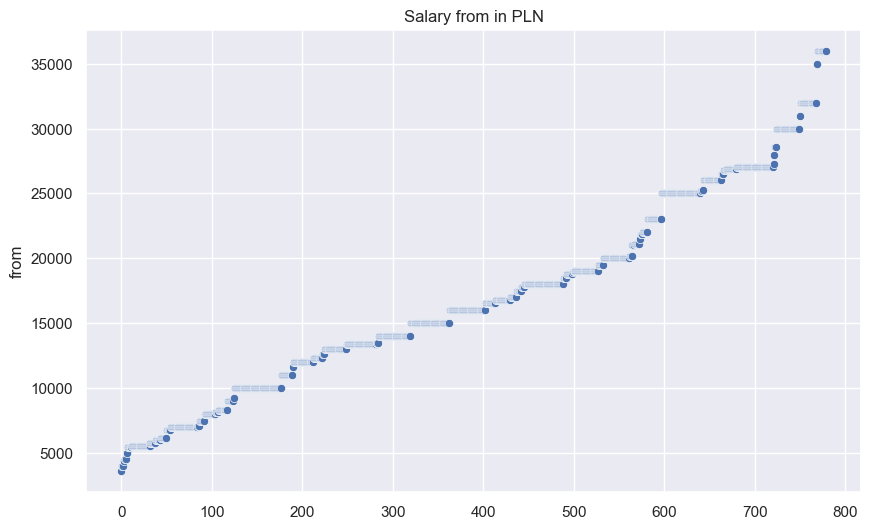

In [81]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.scatterplot(x=np.arange(len(df_salaries_sorted)), y=df_salaries_sorted['from'])
plot.set_title('Salary from in PLN')

plt.show()

In [82]:
# split the dataset into training and test sets, now only salary_from is investigated
X = df_salaries.drop(columns=['from','to'])
y = df_salaries['from']

In [83]:
# normalizing the data
scl = StandardScaler()
X_scaled = pd.DataFrame(scl.fit_transform(X), columns = X.columns)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

## Random Forest

In [85]:
# Initialize the RandomForestRegressor model
rf_regressor = RandomForestRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
gs = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
gs.fit(X_train, y_train)

# Get the best model with tuned hyperparameters
best_model = gs.best_estimator_

# Print best parameters
print("Best Parameters:", gs.best_params_)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
evaluate_regression_model(best_model, X_test, y_test)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Regression Model Evaluation:
Mean Absolute Error (MAE): 543.35
Mean Squared Error (MSE): 2995933.21
Root Mean Squared Error (RMSE): 1730.88
R-squared (R2): 0.94


In [86]:
RF_model = RandomForestRegressor(max_depth=None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)
RF_model.fit(X_train, y_train)

evaluate_regression_model(RF_model, X_test, y_test)

Regression Model Evaluation:
Mean Absolute Error (MAE): 567.44
Mean Squared Error (MSE): 2918162.08
Root Mean Squared Error (RMSE): 1708.26
R-squared (R2): 0.94


##MAE distribution

<Axes: ylabel='Count'>

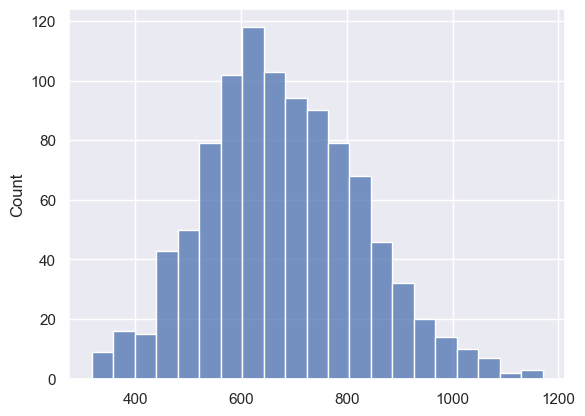

In [87]:
mae = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    RF_model = RandomForestRegressor(max_depth=20, min_samples_split = 2, n_estimators = 150)

    RF_model.fit(X_train, y_train)

    mae.append(mean_absolute_error(y_test, RF_model.predict(X_test)))

sns.set_style("darkgrid")
sns.histplot(mae)

In [92]:
import pickle

with open('RF_model', 'wb') as f:
    pickle.dump(RF_model, f)

In [95]:
import sklearn
scikit_version = sklearn.__version__
print(scikit_version)

1.2.2


In [96]:
joblib.dump(RF_model, f"RF_model_{scikit_version}.pkl")

['RF_model_1.2.2.pkl']

# Reading job offer and preparing the data

In [199]:
job_offer = 'https://justjoin.it/offers/opi-pib-analityk-danych-warszawa'
job_offer_api = job_offer.replace("https://justjoin.it/offers/", "https://justjoin.it/api/offers/")

In [200]:
response = requests.get(job_offer_api)
job_data = response.json()

In [201]:
with open('output.txt', 'r') as file:
    lines = file.readlines()
    top_20_skills = [line.strip() for line in lines]

print(top_20_skills)

['sql', 'python', 'english', 'power bi', 'aws', 'etl', 'java', 'azure', 'oracle', 'databricks', 'big data', 'snowflake', 'scala', 'data', 'machine learning', 'spark', 'pl/sql', 'dwh', 'gcp', 'databases']


In [202]:
offer_data = []

for skill in job_data['skills']:
    # print(skill['name'])
    new_row = job_data.copy()
    new_row['skill_name'] = skill['name']
    new_row['skill_level'] = skill['level']
    offer_data.append(new_row)


offer_df = pd.DataFrame(offer_data)
offer_df = standardize_text(offer_df, "title")
offer_df = standardize_text(offer_df, "skill_name")

offer_dummies = pd.DataFrame()

for col_name in sorted(top_20_skills):
    offer_dummies["skill_" + col_name] = 0

offer_dummies.loc[0] = 0

In [203]:
final = []
for skill in offer_df['skill_name']:
    new_dummy = offer_dummies.copy()
    if skill in top_20_skills:
        new_dummy[f"skill_{skill}"] = 1
    final.append(new_dummy)

all_dummies = pd.concat(final, ignore_index=True)

In [204]:



for col in all_dummies.columns:
    all_dummies[col] *=  common_skills_offer_df['skill_level']

# Dołączanie kolumn dummies
aggregated_offer_df = pd.concat([common_skills_offer_df, all_dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_offer_df = aggregated_offer_df.drop('skill_name', axis=1)
aggregated_offer_df = aggregated_offer_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_offer_df = aggregated_offer_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_offer_df = aggregated_offer_df.drop('skill_level', axis=1)

label_encoder = preprocessing.LabelEncoder()
aggregated_offer_df['experience_level']= label_encoder.fit_transform(aggregated_offer_df['experience_level'])
aggregated_offer_df['workplace_type']= label_encoder.fit_transform(aggregated_offer_df['workplace_type'])
aggregated_offer_df['country_code']= label_encoder.fit_transform(aggregated_offer_df['country_code'])



In [205]:
aggregated_offer_df.sample()

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_java,skill_machine learning,skill_oracle,skill_pl/sql,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql
0,dataconsulting-pl-data-engineer,None,data engineer,al. Jana Pawła II 11,Warszawa,0,"al. Jana Pawła II 11, Warszawa",data,0,dataconsulting.pl,...,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,4.0


In [206]:
offer_employment_types = aggregated_offer_df['employment_types'].apply(pd.Series)
offer_employment_type = offer_employment_types[0].apply(pd.Series)
offer_employment_type= pd.concat([offer_employment_type.drop(['salary'], axis=1),
                                 offer_employment_type['salary'].apply(pd.Series)], axis=1)

offer_no_employment = aggregated_offer_df.drop(columns = 'employment_types')
offer_employment = pd.concat([offer_no_employment, offer_employment_type], axis = 1)

offer_employment['type']= label_encoder.fit_transform(offer_employment['type'])

offer_employment.reset_index(drop=True, inplace = True)

company_size_offer = offer_employment[offer_employment['company_size'].str.contains('-')][['company_size']]

company_size_offer['company_size_1'] = company_size_offer['company_size'].str.split('-').str[0]
company_size_offer['company_size_2']  = company_size_offer['company_size'].str.split('-').str[-1]

company_size_offer['company_size_1'] = pd.to_numeric(company_size_offer['company_size_1'])
company_size_offer['company_size_2'] = pd.to_numeric(company_size_offer['company_size_2'])
company_size_offer['avg_company_size'] = (company_size_offer['company_size_1'] + company_size_offer['company_size_2']) / 2

company_size_offer = company_size_offer[['avg_company_size']]

offer = pd.merge(offer_employment, company_size_offer, left_index=True, right_index=True, how = 'outer')

offer['company_size'] = offer['company_size'].apply(remove_mark)
offer['company_size'] = offer['company_size'].apply(remove_mark)
offer['company_size'] = offer['company_size'].apply(remove_blanc)

offer['avg_company_size'] = offer.apply(
    lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
    axis=1
).astype('float')

offer=offer.drop(columns = ['id', 'from', 'to', 'currency', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation'])

offer_scaled = pd.DataFrame(scl.fit_transform(offer), columns = offer.columns)

In [211]:
offer

,country_code,workplace_type,experience_level,remote,skill_aws,skill_azure,skill_big data,skill_data,skill_databases,skill_databricks,...,skill_oracle,skill_pl/sql,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,type,avg_company_size
0,0,0,0,True,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,4.0,0.0,0.0,0.0,4.0,0,15.0


In [209]:
# Predict on the test set
pred = RF_model.predict(offer_scaled)

In [210]:
print(pred)

[12374.10666667]
